In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels

In [ ]:
def convert_timed_df(df, date, inplace=False):
    if inplace:
        work_df = df
    else:
        work_df = df.copy()
    work_df[date] = pd.to_datetime(df[date])
    work_df.set_index(date, inplace=True)
    work_df.sort_index(inplace=True)
    if not inplace:
        return work_df

In [1]:
def plot_over_time(df, features):
    for feature in features:
        df[feature].plot()
        plt.title(feature)
        plt.show()

In [ ]:
def add_rolling(df, features, windows, inplace=False):
    work_df = pd.DataFrame()
    for feature in features:
        for window in windows:
            work_df[f'{feature}_rolling_{window}_mean'] = df[feature].rolling(window=window).mean()
            work_df[f'{feature}_rolling_{window}_max'] = df[feature].rolling(window=window).max()
            work_df[f'{feature}_rolling_{window}_min'] = df[feature].rolling(window=window).min()
            work_df[f'{feature}_rolling_{window}_std'] = df[feature].rolling(window=window).std()
        work_df[feature] = df[feature]
    if inplace:
        df = work_df
    else:
        return work_df

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
def plot_components(df, resample, method='mean', feature=None):
    if not feature:
        feature = df.columns[0]
    if method == 'mean':
        fig = seasonal_decompose(df[feature].resample(resample).mean()).plot()
    elif method == 'min':
        fig = seasonal_decompose(df[feature].resample(resample).min()).plot()
    elif method == 'max':
        fig = seasonal_decompose(df[feature].resample(resample).max()).plot()
    else:
        print('method arg must be [min/max/mean] (strings)')

In [ ]:
from statsmodels.tsa.stattools import adfuller
def is_stat(df, feature, window=50):
    rolmeans = df.rolling(window=window, center=False).mean()
    rolstd = df.rolling(window=window, center=False).std()
    dftest = adfuller(df[feature])
    if dftest[1] <= 0.05:
        return True
    else:
        return False

In [ ]:
from sklearn.model_selection import train_test_split
def time_split(df, val, test=None):
    if test == None:
        return train_test_split(df, test_size=val, shuffle=False)
    else:
        df_train, df_val = train_test_split(df, test_size=(val+test), shuffle=False)
        df_val, df_test = train_test_split(df_val, test_size=test/(val+test), shuffle=False)
        return df_train, df_val, df_test

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
def show_autocorrelations(df, feature=None):
    if not feature:
        feature = df.columns[0]
    plot_acf(df[feature].diff(periods=1).dropna())
    plot_pacf(df[feature].diff(periods=1).dropna());

In [2]:
data = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'

In [3]:
pd.read_csv(data)

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
...,...,...
3645,1990-12-27,14.0
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7


In [ ]:
df = pd.read_csv(data, usecols=['Date', 'Temp'], index_col='Date', parse_dates=True)

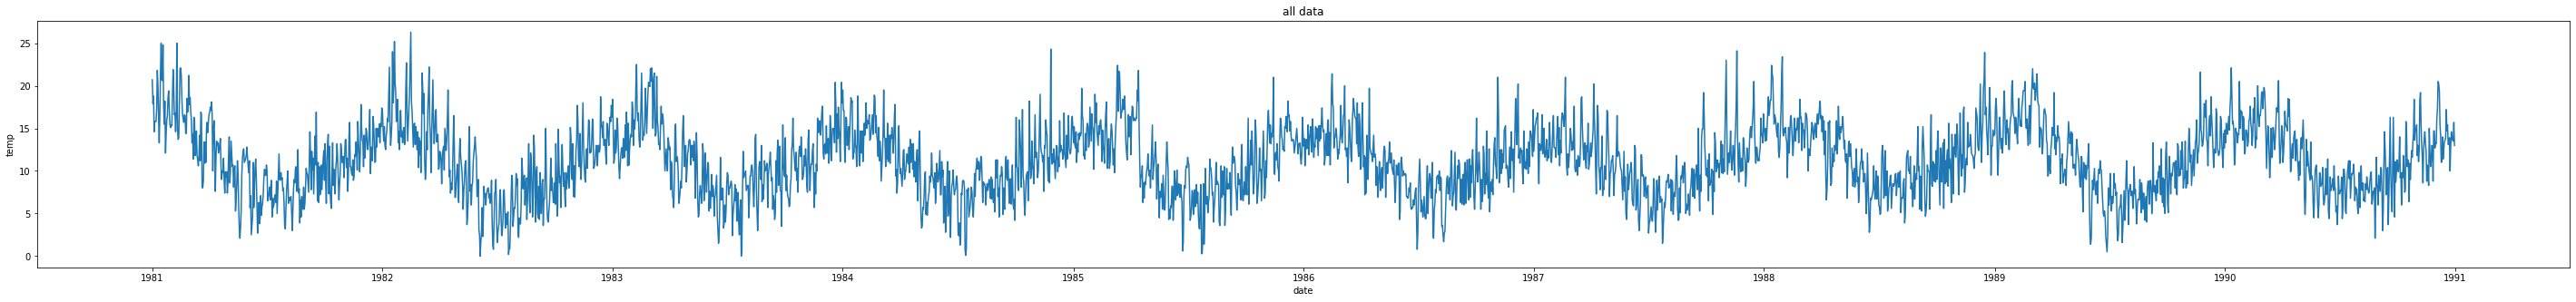

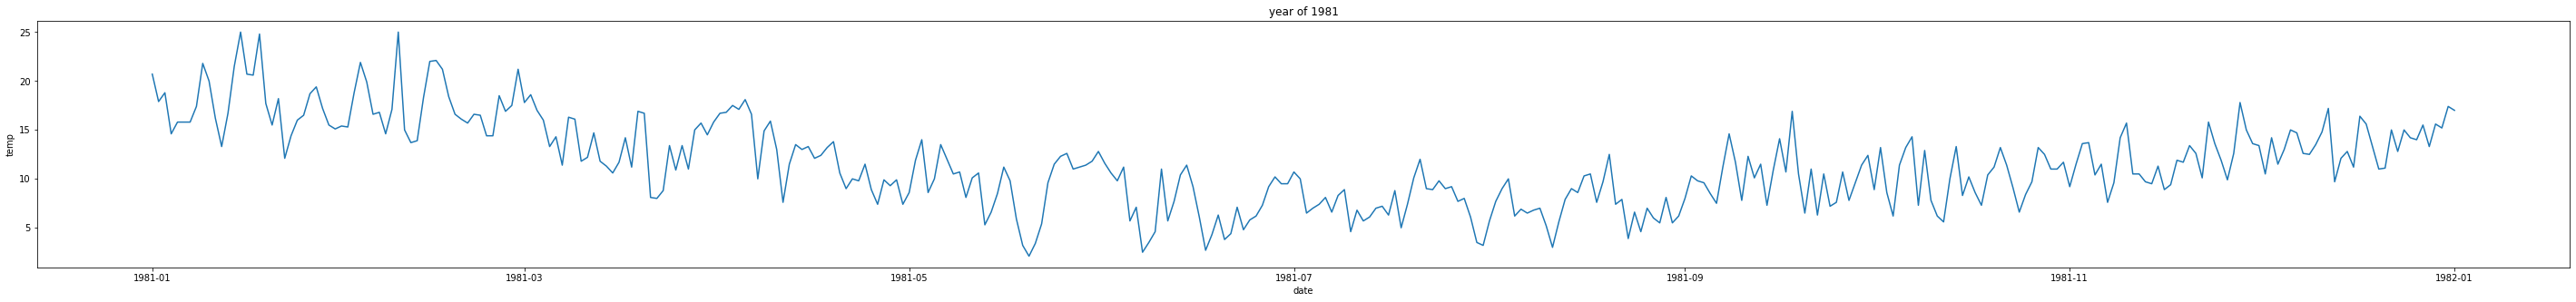

In [ ]:
plt.figure(figsize=(50,5))
plt.plot(df)
plt.xlabel('date')
plt.ylabel('temp')
plt.title('all data')
plt.show()

plt.figure(figsize=(50,5))
plt.plot(df['01-01-1981':'01-01-1982'])

# plt.plot(df['1981'])
plt.xlabel('date')
plt.ylabel('temp')
plt.title('year of 1981')
plt.show()

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose
def plot_components(df, sampled, feature=None):
    if not feature:
        feature = df.columns[0]
    fig = seasonal_decompose(df[features].resample(sampled).min()).plot()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


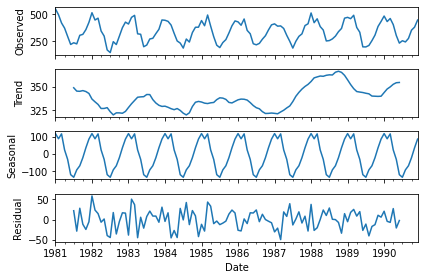

In [ ]:
resampled = df.resample('m').sum()['Temp']    # change the resample y/m/d/

fig = seasonal_decompose(resampled).plot()

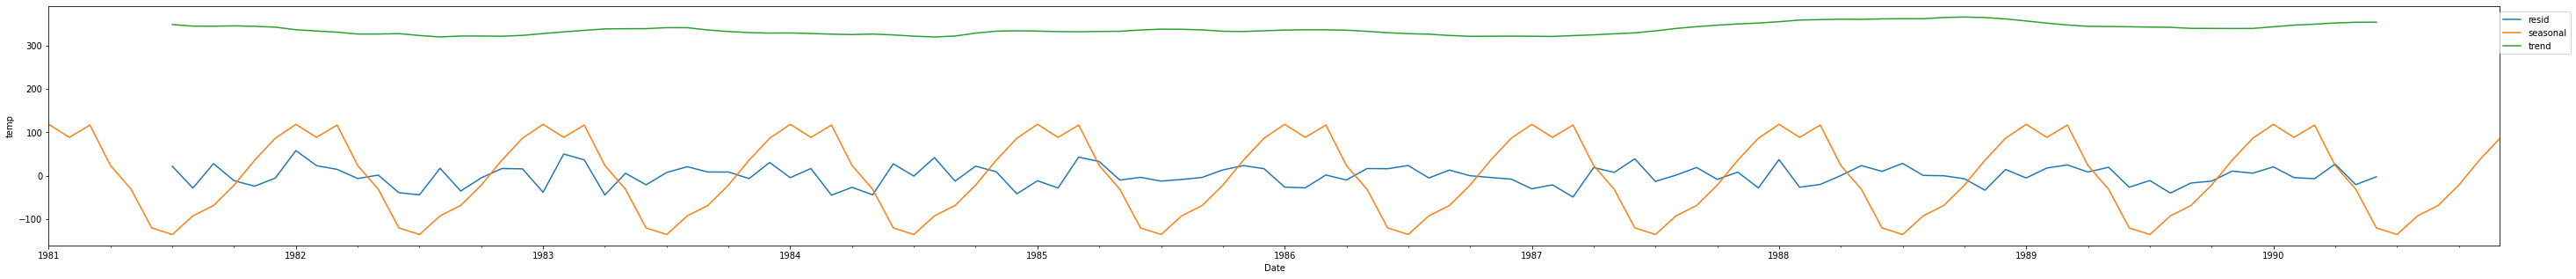

In [ ]:
decopose = seasonal_decompose(resampled)
plt.figure(figsize=(50,5))
decopose.resid.plot(label="resid")
decopose.seasonal.plot(label="seasonal")
decopose.trend.plot(label="trend")
plt.legend(loc=(1,0.8))
plt.ylabel("temp")
plt.show()

We can see that the trend is constant so the series is stationary, cunducting Dickey-Fuller hypothesis testing

Dickey-Fuller Hypothesis testing:
> This hypothesis checks if the series is stationary or not
> 
> Null Hypothesis: The searies is not stationary
>
> Alternate Hypothesis: The searies is stationary

Code stipped from https://medium.com/analytics-vidhya/time-series-forecasting-sarima-vs-auto-arima-models-f95e76d71d8f

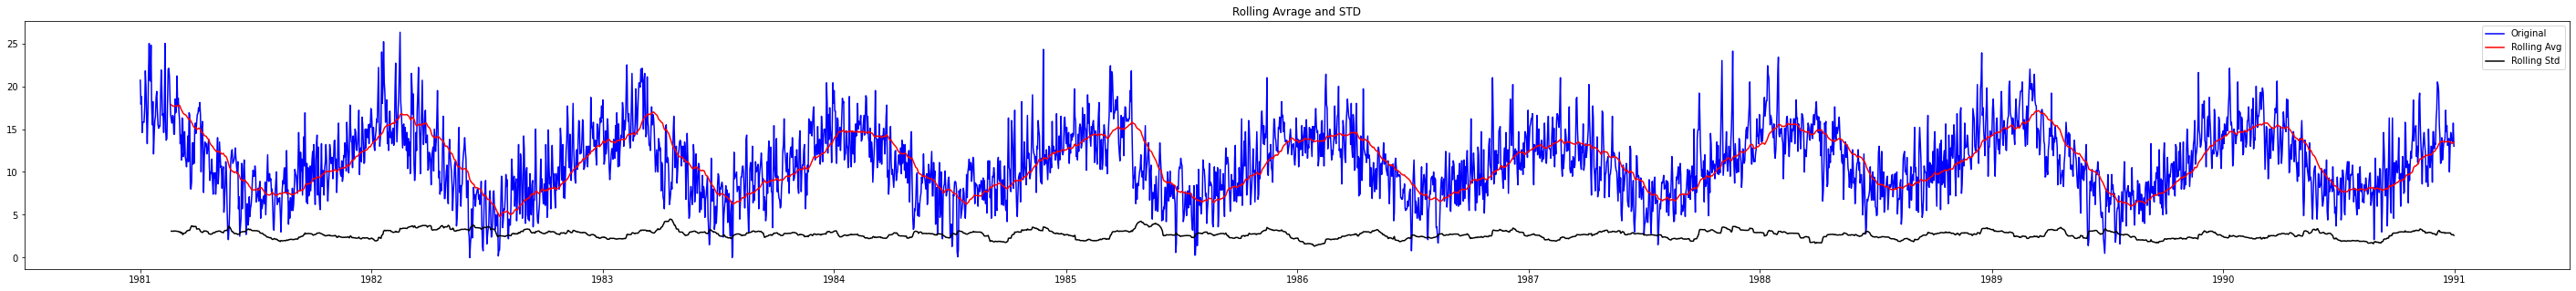

Test statistic                    -4.444805
p-value                            0.000247
#Lags used                        20.000000
#Number of Observations Used    3629.000000
Critical value 1%                 -3.432153
Critical value 5%                 -2.862337
Critical value 10%                -2.567194
dtype: float64


In [ ]:
from statsmodels.tsa.stattools import adfuller

rolmeans = df.rolling(window=50, center=False).mean()
rolstd = df.rolling(window=50, center=False).std()

dftest = adfuller(df['Temp'])

plt.figure(figsize=(50,5))
plt.plot(df, color='blue', label='Original')
plt.plot(rolmeans, color='red', label='Rolling Avg')
plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Avrage and STD')
plt.show(block=False)

dfoutput = pd.Series(dftest[0:4], index=['Test statistic', 'p-value', 
                                         '#Lags used', 
                                         '#Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput[f'Critical value {key}'] = value
print(dfoutput)


p-value is less then 0.05 so we will reject the null hypothesis -> The searies is stationary

In [ ]:
(df.index[1:] - df.index[:-1]) # getting the time spaces

TimedeltaIndex(['1 days', '1 days', '1 days', '1 days', '1 days', '1 days',
                '1 days', '1 days', '1 days', '1 days',
                ...
                '1 days', '1 days', '1 days', '1 days', '1 days', '1 days',
                '1 days', '1 days', '1 days', '1 days'],
               dtype='timedelta64[ns]', name='Date', length=3649, freq=None)

Split for prediction

In [ ]:
ratio = 0.05   #  test set is 5%
train = df[:int(df.shape[0]*(1-ratio))]['Temp']
test = df[int(df.shape[0]*(1-ratio)):]['Temp']

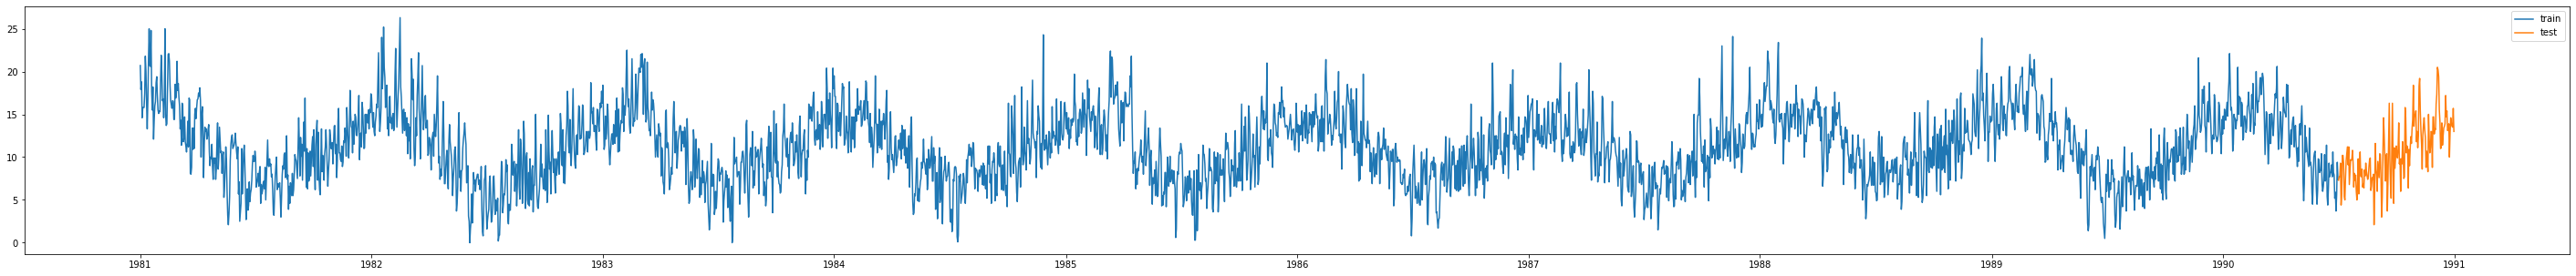

In [ ]:
plt.figure(figsize=(50,5))
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.legend()
plt.show()

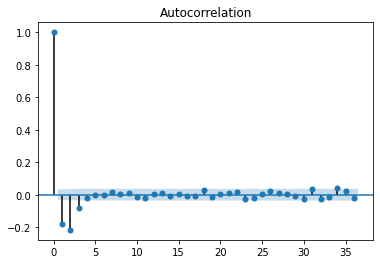

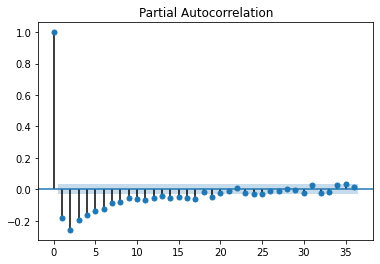

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(train.diff(periods=1).dropna())
plot_pacf(train.diff(periods=1).dropna());

From ACF -> MA(4)

From PACF -> AR(17)

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
# from statsmodels.tsa.arima.model import ARIMA

from tqdm import tqdm
history = train.to_list()
predictions = []

for t in tqdm(range(len(test))):
    model = ARIMA(history, order=(2,1,1))    # order=(4,1,17)
    model_fit = model.fit()
    predict = model_fit.forecast()[0]
    history.append(test[t])
    predictions.append(predict)


 16%|█▌        | 29/183 [00:29<02:35,  1.01s/it]/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
100%|██████████| 183/183 [03:05<00:00,  1.01s/it]


In [ ]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 3648
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -8384.263
Method:                       css-mle   S.D. of innovations              2.409
Date:                Wed, 17 Feb 2021   AIC                          16778.526
Time:                        07:06:06   BIC                          16809.536
Sample:                             1   HQIC                         16789.570
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.006     -0.179      0.858      -0.013       0.011
ar.L1.D.y      0.4966      0.018     27.345      0.000       0.461       0.532
ar.L2.D.y     -0.1296      0.017     -7.425      0.000      -0.164      -0.095
ma.L1.D.y     -0.9008      0.009   -104.762      0.000      -0.918      -0.884
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.9160           -2.0115j            2.7780           -0.1289
AR.2            1.9160           +2.0115j            2.7780            0.1289
MA.1            1.1101           +0.0000j            1.1101            0.0000
-----------------------------------------------------------------------------
"""

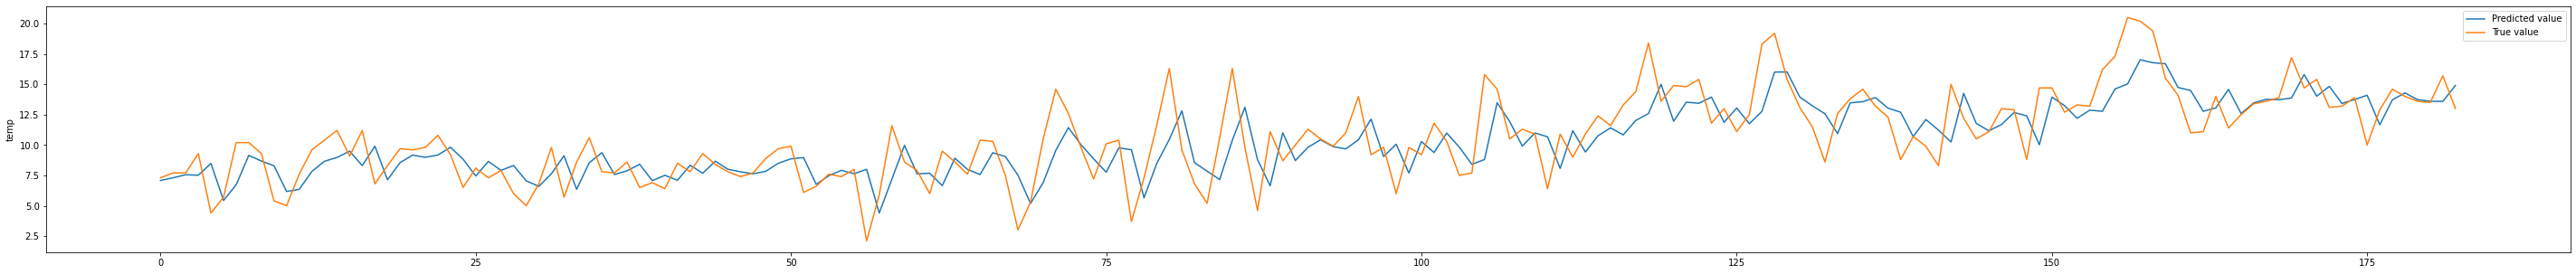

RMSE: 810.8347505828506


In [ ]:
plt.figure(figsize=(50,5))
plt.plot(predictions, label='Predicted value')
plt.plot(test.values, label='True value')
plt.ylabel('temp')
plt.legend()
plt.xlim()
plt.show()

RMSE = np.sqrt(((np.array(predictions) - test.values)**2).sum())
print(f'RMSE: {RMSE}')

predict next 10 days

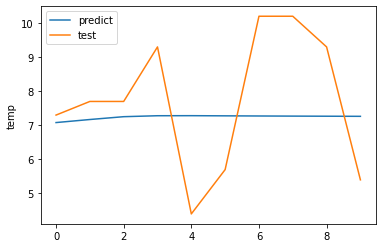

In [ ]:
n=10  # number of days to predict
model = ARIMA(train.values, order=(2,1,1))
model_fit = model.fit()
plt.plot(model_fit.forecast(n)[0], label='predict')
plt.plot(test[:n].values, label='test')
plt.ylabel('temp')
plt.legend()
plt.show()

# Working with prophet

In [ ]:
from fbprophet import Prophet

In [ ]:
URL = 'https://raw.githubusercontent.com/facebook/prophet/master/examples/example_wp_log_peyton_manning.csv'
df = pd.read_csv(URL)
df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


In [ ]:
df = pd.read_csv(URL, usecols=['ds', 'y'], index_col='ds', parse_dates=True)

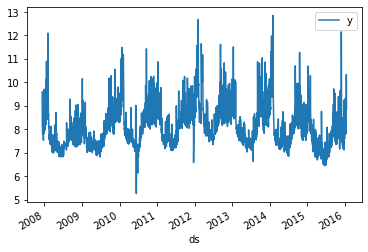

In [ ]:
df.plot()
plt.show()

In [ ]:
df_2 = pd.DataFrame()
df_2['ds'] = df.index
df_2['y'] = df['y'].values
df_2

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572
...,...,...
2900,2016-01-16,7.817223
2901,2016-01-17,9.273878
2902,2016-01-18,10.333775
2903,2016-01-19,9.125871


In [ ]:
m = Prophet()
m.fit(df_2)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


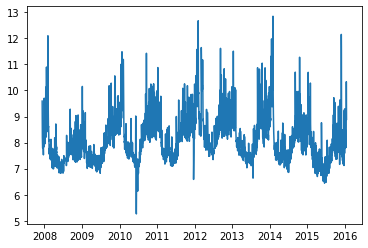

In [ ]:
plt.plot(df_2['ds'], df_2['y'])

In [ ]:
future = m.make_future_dataframe(periods=365*3)
future.tail()

,ds
3995,2019-01-15
3996,2019-01-16
3997,2019-01-17
3998,2019-01-18
3999,2019-01-19


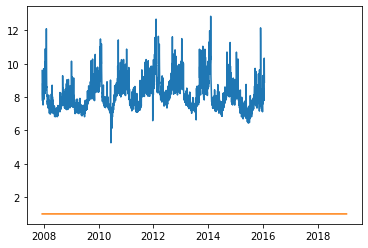

In [ ]:
plt.plot(df_2['ds'], df_2['y'])
plt.plot(future['ds'], np.ones(len(future)))

In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3995,2019-01-15,7.505484,5.602628,9.595701
3996,2019-01-16,7.340579,5.503415,9.372470
3997,2019-01-17,7.355523,5.406609,9.515429
3998,2019-01-18,7.377704,5.425274,9.516831
3999,2019-01-19,7.153798,5.179343,9.366423


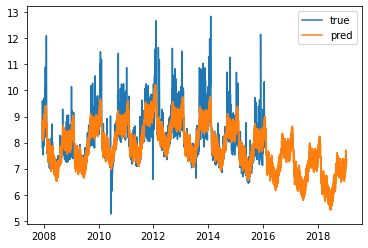

In [ ]:
plt.plot(df_2['ds'], df_2['y'], label='true')
plt.plot(forecast['ds'], forecast['yhat'], label='pred')
plt.legend()
plt.show()


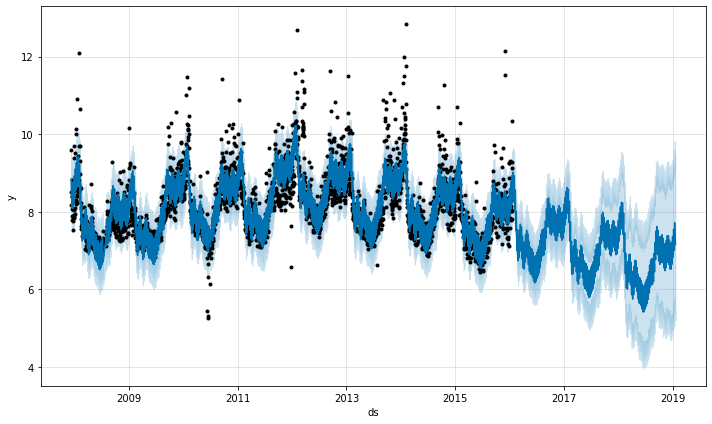

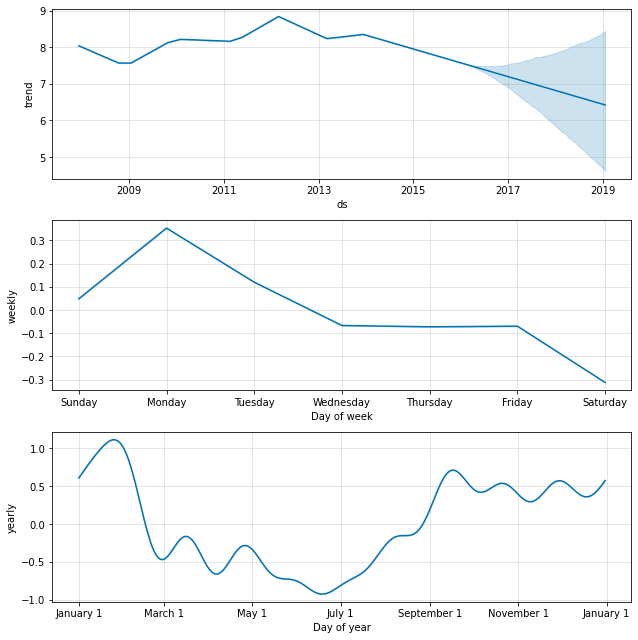

In [ ]:
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

In [ ]:
plot_components_plotly(m, forecast)

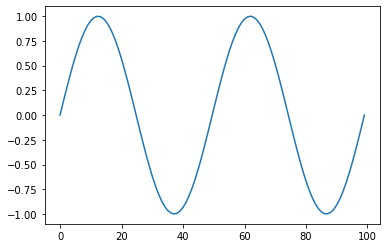

In [ ]:
X = np.linspace(-2*np.pi, 2*np.pi,100)
y = np.sin(X)
plt.plot(y);

In [ ]:
df_p = pd.DataFrame()
df_p['ds'] = X
df_p['y'] = y

In [ ]:
m = Prophet(daily_seasonality=True)
m.fit(df_p)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [ ]:
pd.date_range('01.01.2000', periods=365)

DatetimeIndex(['2000-01-01', '2000-01-02', '2000-01-03', '2000-01-04',
               '2000-01-05', '2000-01-06', '2000-01-07', '2000-01-08',
               '2000-01-09', '2000-01-10',
               ...
               '2000-12-21', '2000-12-22', '2000-12-23', '2000-12-24',
               '2000-12-25', '2000-12-26', '2000-12-27', '2000-12-28',
               '2000-12-29', '2000-12-30'],
              dtype='datetime64[ns]', length=365, freq='D')

In [ ]:
future = m.make_future_dataframe(periods=50)
future.tail()

,ds
145,1970-02-16 00:00:00.000000006
146,1970-02-17 00:00:00.000000006
147,1970-02-18 00:00:00.000000006
148,1970-02-19 00:00:00.000000006
149,1970-02-20 00:00:00.000000006


In [4]:
web = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00357/occupancy_data.zip'

In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

MemoryError: ignored